In [1]:
# all necessary includes

import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords

import os
import nltk
# nltk.download('stopwords')
from string import punctuation
from pymystem3 import Mystem
import re

## Построение датафрейма

In [2]:
# additional functions
mystem = Mystem()
garbage_words = stopwords.words('english') + stopwords.words('russian')

def BuildDataFrame(cur_folder, doc_types, file_names, doc_texts, name=''):
    files = os.listdir()
    cur_name = name[:]
    if len(cur_name) != 0:
        cur_name += '-'
    cur_name += cur_folder
    if 'text_layer' in files:
        files.remove('text_layer')
        print('in', cur_name)
        
    folders = [file for file in files if '.' not in file]
    
    for folder in folders:
        os.chdir(folder)
        BuildDataFrame(folder, doc_types, file_names, doc_texts, cur_name)
        os.chdir('..')
    if len(folders) == 0:
        for file in files:
            text_layer = ''
            if 'text_layer' in os.listdir():
                try:
                    with open('./text_layer/' + file.split('.')[0] + '.txt') as f:
                        text_layer = f.read()
                except:
                    NOT_FOUND.append((file, cur_name))
            if len(text_layer) > 0:
                doc_texts.append(text_layer)
                doc_types.append(cur_name)
                file_names.append(file)
        

Документы для тестового и тренировочного сетов распределены по папкам, причем тип документа определяется тем, по какому пути он лежит, например если документ лежит в папке ad/invoice/first, то его тип: ad-invoice-first.

Для формирования датафрейма пройдемся по папкам с документами, соберем все предварительно снятые текстовые слои документов и типы этих документов.

In [3]:
# build dataframe
NOT_FOUND = []
doc_types, file_names, doc_texts = [], [], []
dataset_path = 'for training'
os.chdir(dataset_path)
BuildDataFrame('', doc_types, file_names, doc_texts)
os.chdir('..')
df = pd.DataFrame({'file_name': file_names, 'doc_type': doc_types, 'doc_text' : doc_texts})

in ad-error
in ad-invoice-first
in ad-invoice-multi
in ad-statement-first
in ad-statement-multi
in ad-upd-first
in ad-upd-multi
in ad-waybill-first
in ad-waybill-multi
in rfq-AOG
in rfq-CRITICAL
in rfq-Routine
in rfq-Spam
in sec-error
in sec-Изменение контроля
in sec-Кросс-дефолт
in sec-Обозначение прав дочерних компаний
in sec-Оговорки о коллективных действиях
in sec-Ограничение деятельности
in sec-Ограничение задолженности
in sec-Ограничение задолженности дочерних компаний
in sec-Ограничение по инвестициям
in sec-Ограничение по наслоению долговых обязательств по рангам
in sec-Ограничение по платежам
in sec-Ограничение по платежам в отношении дочерних компаний
in sec-Ограничение по предоставлению залога
in sec-Ограничение по продаже активов
in sec-Ограничение по продаже активов с обратной арендой
in sec-Ограничение по слиянию
in sec-Ограничение по транзакциям с аффилированными лицами
in sec-Случаи дефолта
in sec-Триггер рейтингов
in sec-Условие приостановки действия ковенантов
in sec-

In [4]:
# part for checking files that weren't found
ext = [x[0].split('.')[-1] for x in NOT_FOUND]
print(set(ext))
formated_not_found = ['file {} at {} not found'.format(x[0], x[1]) for x in NOT_FOUND if '' in x[0].split('.')[-1].lower()]
print(len(formated_not_found))
print('\n'.join(formated_not_found))

{'msg', 'pdf', 'JPEG', 'PDF', 'jpg'}
49
file 06014769-9ae4-458d-a7cb-8ade56355dd6.pdf at ad-error not found
file 1012b487-da5b-43b3-91b5-1862e8b07c5a.pdf at ad-error not found
file 10f6b3f1-bcaa-49c6-af90-4493d6d50cbd.pdf at ad-error not found
file 19596038-1690-4aa0-84aa-162381f70581.pdf at ad-error not found
file 1e9ba652-ca81-4eec-9208-d0dfad11469b.pdf at ad-error not found
file 1f6f9a23-d9c4-4ed8-be3b-89afd4c77568.pdf at ad-error not found
file 25cbeedc-2612-4784-86de-0e139945707b.pdf at ad-error not found
file 29dcc2e1-9a68-49c1-9d43-741cf491d5dc.pdf at ad-error not found
file 2a4d3482-25d4-403b-9a0d-4b41841d44b3.pdf at ad-error not found
file 369310e4-850d-46bb-a756-151af523810a.pdf at ad-error not found
file 41aebe14-3183-46a1-b4fd-3a1513b787c7.pdf at ad-error not found
file 4889bca2-01e1-4c31-bacb-0632f36878c8.pdf at ad-error not found
file 4a753c6d-80d7-4cc9-b0e8-0192b82f0377.PDF at ad-error not found
file 51a0488a-44cd-4956-b749-998de144527b.pdf at ad-error not found
file 544

Проведем очистку текста от мусорных слов и пунктуации.

In [5]:
def ClearText(text, garbage_words):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[().,:-]', '', text).replace('\n', ' ')
    # text = ' '.join([word for word in text.lower().split() if word not in garbage_words and word.strip() not in punctuation])
    # tokens = mystem.lemmatize(text.lower())
    tokens = text.lower().split()
    tokens = [token for token in tokens if token not in garbage_words and token != ' ' and token.strip() not in punctuation]
    text = ' '.join(tokens)
    return text

In [6]:
for i in range(len(df['doc_text'])):
    df['doc_text'][i] = ClearText(df['doc_text'][i], garbage_words)
df = df.rename(columns={'doc_type' : 'target', 'doc_text' : 'X'})

In [85]:
from wordcloud import WordCloud

In [96]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ' '.join(corpus)
   # for i in corpus:
    #    str_corpus += ' ' + i
   # str_corpus = str_corpus.strip()
   # print(str_corpus)
    return str_corpus
# Получение списка всех слов в корпусе
def get_corpus(data):
    text = ' '.join(data)
    #corpus = [word for word in ]
    #for phrase in data:
        #corpus += phrase.split()
        #for word in phrase.split():
         #   corpus.append(word)
    return text.split()
# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=garbage_words,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(corpus)
    return wordCloud

print(len(df['X'].values))

procWordCloud = get_wordCloud(' '.join(df['X'].values))
print('got wordcloud')
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

24367
got corpus 916


KeyboardInterrupt: 

Посмотрим на процентное соотношение типов документов в датафрейме

In [7]:
types_list = list(set(df['target']))
types_fra = [len(df[df['target']  == tp]) / len(df) for tp in types_list]
stat = pd.DataFrame({'target': types_list, 'percentage' : types_fra}).sort_values('percentage')
stat

,target,percentage
20,sec-Ограничение по инвестициям,0.000041
4,sec-Ограничение по наслоению долговых обязател...,0.000246
0,sec-Ограничение по платежам в отношении дочерн...,0.000451
25,sec-Условие приостановки действия ковенантов,0.000451
3,sec-Ограничение по платежам,0.000492
5,sec-Ограничение задолженности дочерних компаний,0.000534
28,sec-Обозначение прав дочерних компаний,0.000534
23,sec-Ограничение задолженности,0.000575
10,sec-Ограничение по продаже активов с обратной ...,0.000575
21,sec-Ограничение по продаже активов,0.000575


In [8]:
# split dataframe into samples with same proportion of each document class
def SplitTrainSample(dataframe, fraction=0.7):
    types = set(dataframe['target'])
    dataframes = [dataframe[dataframe['target'] == doc_type] for doc_type in types]
    splited = [np.split(df.sample(frac=1), [int(fraction * len(df))]) for df in dataframes]
    test = [df[0] for df in splited]
    train = [df[1] for df in splited]
    return pd.concat(train).sample(frac=1), pd.concat(test).sample(frac=1)


def CreateVectorizer(ngram_range, max_features):
    return CountVectorizer(analyzer = "word",
                           #min_df=5,
                           #max_df=0.7,
                           tokenizer = None,
                           preprocessor = None,
                           stop_words = None,
                           ngram_range = ngram_range,
                           max_features = max_features
                         )

In [9]:
# split into training (0.6 of dataframe) validation (0.2 of dataframe) and test (0.2 of dataframe)

train, test = SplitTrainSample(df, fraction=0.7)
X_train, Y_train = train['X'], train['target']
vectorizer = CreateVectorizer((1, 3), 50000)
X_train = vectorizer.fit_transform(X_train)

Проведем несколько кросс валидаций, чтобы выявить значения параметров, при которых классификатор дает наиболее хорошие результаты.

Запустим несколько кросс валидаций по параметрам: 
* n_estimators
* max_features 
* max_depth 
* min_samples_split
* min_samples_leaf
* bootstrap

На первом этапе с помощью случайной валидации выделим диапазоны значений параметров, которые дают наилучшие результаты по точности классификатора.

Далее будем отсеивать диапазоны  параметров, которые дают плохие результаты.

## Первый раунд рандомизированной кросс валидации. 
Отсеим диапазоны значений параметров, которые дают плохие результаты.

In [147]:
n_estimators = [int(x) for x in np.linspace(start=90, stop=500, num=15)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start=10, stop=300, num=15)] + [None]
min_samples_split = [int(x) for x in np.linspace(start=5, stop=55, num=10)]
min_samples_leaf = [int(x) for x in np.linspace(start=1, stop=50, num=11)]
bootstrap = [True, False]

param_dist = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf,
    'bootstrap' : bootstrap,
}
for key in param_dist.keys():
    print('{}: {}'.format(key, param_dist[key]))

n_estimators: [90, 119, 148, 177, 207, 236, 265, 295, 324, 353, 382, 412, 441, 470, 500]
max_features: ['log2', 'sqrt']
max_depth: [10, 30, 51, 72, 92, 113, 134, 155, 175, 196, 217, 237, 258, 279, 300, None]
min_samples_split: [5, 10, 16, 21, 27, 32, 38, 43, 49, 55]
min_samples_leaf: [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
bootstrap: [True, False]


In [82]:
def RunRandomizedCrossValidation(base_rf, params, cv, n_iters):
    rs = RandomizedSearchCV(base_rf,
                        params,
                        n_iter=n_iters,
                        cv=cv,
                        verbose=3,
                        n_jobs=1,
                        random_state=0,
                        scoring='accuracy')
    rs.fit(X_train, Y_train)
    return rs

In [111]:
# rf = RandomForestClassifier(bootstrap=False, max_features='sqrt', min_samples_leaf=1)
rs = RunRandomizedCrossValidation(RandomForestClassifier(), param_dist, 3, 170)

Fitting 3 folds for each of 170 candidates, totalling 510 fits


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


[CV 1/3] END bootstrap=False, max_depth=92, max_features=sqrt, min_samples_leaf=20, min_samples_split=10, n_estimators=177;, score=0.820 total time=   4.3s
[CV 2/3] END bootstrap=False, max_depth=92, max_features=sqrt, min_samples_leaf=20, min_samples_split=10, n_estimators=177;, score=0.812 total time=   4.6s
[CV 3/3] END bootstrap=False, max_depth=92, max_features=sqrt, min_samples_leaf=20, min_samples_split=10, n_estimators=177;, score=0.818 total time=   4.7s
[CV 1/3] END bootstrap=True, max_depth=279, max_features=log2, min_samples_leaf=20, min_samples_split=27, n_estimators=295;, score=0.546 total time=   2.8s
[CV 2/3] END bootstrap=True, max_depth=279, max_features=log2, min_samples_leaf=20, min_samples_split=27, n_estimators=295;, score=0.543 total time=   2.7s
[CV 3/3] END bootstrap=True, max_depth=279, max_features=log2, min_samples_leaf=20, min_samples_split=27, n_estimators=295;, score=0.563 total time=   2.6s
[CV 1/3] END bootstrap=True, max_depth=258, max_features=sqrt, m

[CV 3/3] END bootstrap=True, max_depth=196, max_features=sqrt, min_samples_leaf=25, min_samples_split=49, n_estimators=382;, score=0.785 total time=   7.1s
[CV 1/3] END bootstrap=True, max_depth=113, max_features=sqrt, min_samples_leaf=25, min_samples_split=32, n_estimators=324;, score=0.787 total time=   5.6s
[CV 2/3] END bootstrap=True, max_depth=113, max_features=sqrt, min_samples_leaf=25, min_samples_split=32, n_estimators=324;, score=0.790 total time=   5.9s
[CV 3/3] END bootstrap=True, max_depth=113, max_features=sqrt, min_samples_leaf=25, min_samples_split=32, n_estimators=324;, score=0.786 total time=   6.2s
[CV 1/3] END bootstrap=False, max_depth=237, max_features=log2, min_samples_leaf=15, min_samples_split=55, n_estimators=177;, score=0.745 total time=   1.7s
[CV 2/3] END bootstrap=False, max_depth=237, max_features=log2, min_samples_leaf=15, min_samples_split=55, n_estimators=177;, score=0.737 total time=   1.7s
[CV 3/3] END bootstrap=False, max_depth=237, max_features=log2

[CV 2/3] END bootstrap=True, max_depth=155, max_features=log2, min_samples_leaf=50, min_samples_split=32, n_estimators=90;, score=0.475 total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=155, max_features=log2, min_samples_leaf=50, min_samples_split=32, n_estimators=90;, score=0.428 total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=196, max_features=sqrt, min_samples_leaf=15, min_samples_split=49, n_estimators=119;, score=0.805 total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=196, max_features=sqrt, min_samples_leaf=15, min_samples_split=49, n_estimators=119;, score=0.807 total time=   2.4s
[CV 3/3] END bootstrap=True, max_depth=196, max_features=sqrt, min_samples_leaf=15, min_samples_split=49, n_estimators=119;, score=0.805 total time=   2.5s
[CV 1/3] END bootstrap=False, max_depth=300, max_features=log2, min_samples_leaf=1, min_samples_split=21, n_estimators=500;, score=0.867 total time=  13.5s
[CV 2/3] END bootstrap=False, max_depth=300, max_features=log2, mi

[CV 1/3] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=38, n_estimators=265;, score=0.847 total time=   7.4s
[CV 2/3] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=38, n_estimators=265;, score=0.844 total time=   7.7s
[CV 3/3] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=38, n_estimators=265;, score=0.846 total time=   7.7s
[CV 1/3] END bootstrap=False, max_depth=237, max_features=sqrt, min_samples_leaf=50, min_samples_split=16, n_estimators=324;, score=0.774 total time=   5.2s
[CV 2/3] END bootstrap=False, max_depth=237, max_features=sqrt, min_samples_leaf=50, min_samples_split=16, n_estimators=324;, score=0.759 total time=   5.3s
[CV 3/3] END bootstrap=False, max_depth=237, max_features=sqrt, min_samples_leaf=50, min_samples_split=16, n_estimators=324;, score=0.771 total time=   5.5s
[CV 1/3] END bootstrap=False, max_depth=30, max_features=sqrt

[CV 3/3] END bootstrap=False, max_depth=175, max_features=log2, min_samples_leaf=30, min_samples_split=27, n_estimators=177;, score=0.551 total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=72, max_features=sqrt, min_samples_leaf=15, min_samples_split=49, n_estimators=500;, score=0.812 total time=   9.4s
[CV 2/3] END bootstrap=True, max_depth=72, max_features=sqrt, min_samples_leaf=15, min_samples_split=49, n_estimators=500;, score=0.804 total time=   9.8s
[CV 3/3] END bootstrap=True, max_depth=72, max_features=sqrt, min_samples_leaf=15, min_samples_split=49, n_estimators=500;, score=0.807 total time=  10.3s
[CV 1/3] END bootstrap=False, max_depth=51, max_features=log2, min_samples_leaf=35, min_samples_split=32, n_estimators=382;, score=0.549 total time=   3.3s
[CV 2/3] END bootstrap=False, max_depth=51, max_features=log2, min_samples_leaf=35, min_samples_split=32, n_estimators=382;, score=0.546 total time=   3.1s
[CV 3/3] END bootstrap=False, max_depth=51, max_features=log2, min

[CV 2/3] END bootstrap=True, max_depth=51, max_features=log2, min_samples_leaf=10, min_samples_split=43, n_estimators=295;, score=0.749 total time=   2.8s
[CV 3/3] END bootstrap=True, max_depth=51, max_features=log2, min_samples_leaf=10, min_samples_split=43, n_estimators=295;, score=0.711 total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=51, max_features=sqrt, min_samples_leaf=35, min_samples_split=38, n_estimators=265;, score=0.758 total time=   4.1s
[CV 2/3] END bootstrap=True, max_depth=51, max_features=sqrt, min_samples_leaf=35, min_samples_split=38, n_estimators=265;, score=0.773 total time=   4.1s
[CV 3/3] END bootstrap=True, max_depth=51, max_features=sqrt, min_samples_leaf=35, min_samples_split=38, n_estimators=265;, score=0.764 total time=   4.1s
[CV 1/3] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=20, min_samples_split=10, n_estimators=177;, score=0.572 total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=30, max_features=log2, min_samp

[CV 1/3] END bootstrap=False, max_depth=300, max_features=sqrt, min_samples_leaf=45, min_samples_split=27, n_estimators=265;, score=0.773 total time=   4.3s
[CV 2/3] END bootstrap=False, max_depth=300, max_features=sqrt, min_samples_leaf=45, min_samples_split=27, n_estimators=265;, score=0.783 total time=   4.6s
[CV 3/3] END bootstrap=False, max_depth=300, max_features=sqrt, min_samples_leaf=45, min_samples_split=27, n_estimators=265;, score=0.775 total time=   4.9s
[CV 1/3] END bootstrap=False, max_depth=72, max_features=log2, min_samples_leaf=1, min_samples_split=21, n_estimators=412;, score=0.843 total time=   8.4s
[CV 2/3] END bootstrap=False, max_depth=72, max_features=log2, min_samples_leaf=1, min_samples_split=21, n_estimators=412;, score=0.840 total time=   8.7s
[CV 3/3] END bootstrap=False, max_depth=72, max_features=log2, min_samples_leaf=1, min_samples_split=21, n_estimators=412;, score=0.842 total time=   9.2s
[CV 1/3] END bootstrap=False, max_depth=237, max_features=sqrt, 

[CV 3/3] END bootstrap=False, max_depth=51, max_features=sqrt, min_samples_leaf=15, min_samples_split=27, n_estimators=382;, score=0.832 total time=  10.3s
[CV 1/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=50, min_samples_split=27, n_estimators=412;, score=0.735 total time=   5.3s
[CV 2/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=50, min_samples_split=27, n_estimators=412;, score=0.722 total time=   5.4s
[CV 3/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=50, min_samples_split=27, n_estimators=412;, score=0.734 total time=   5.7s
[CV 1/3] END bootstrap=False, max_depth=217, max_features=sqrt, min_samples_leaf=20, min_samples_split=43, n_estimators=295;, score=0.820 total time=   6.9s
[CV 2/3] END bootstrap=False, max_depth=217, max_features=sqrt, min_samples_leaf=20, min_samples_split=43, n_estimators=295;, score=0.814 total time=   6.9s
[CV 3/3] END bootstrap=False, max_depth=217, max_features=sqrt, m

[CV 2/3] END bootstrap=False, max_depth=155, max_features=sqrt, min_samples_leaf=35, min_samples_split=38, n_estimators=265;, score=0.791 total time=   5.0s
[CV 3/3] END bootstrap=False, max_depth=155, max_features=sqrt, min_samples_leaf=35, min_samples_split=38, n_estimators=265;, score=0.787 total time=   5.2s
[CV 1/3] END bootstrap=False, max_depth=237, max_features=sqrt, min_samples_leaf=45, min_samples_split=27, n_estimators=412;, score=0.770 total time=   6.6s
[CV 2/3] END bootstrap=False, max_depth=237, max_features=sqrt, min_samples_leaf=45, min_samples_split=27, n_estimators=412;, score=0.781 total time=   6.8s
[CV 3/3] END bootstrap=False, max_depth=237, max_features=sqrt, min_samples_leaf=45, min_samples_split=27, n_estimators=412;, score=0.775 total time=   7.1s
[CV 1/3] END bootstrap=False, max_depth=279, max_features=sqrt, min_samples_leaf=40, min_samples_split=27, n_estimators=119;, score=0.787 total time=   2.1s
[CV 2/3] END bootstrap=False, max_depth=279, max_features=

[CV 1/3] END bootstrap=True, max_depth=92, max_features=log2, min_samples_leaf=10, min_samples_split=55, n_estimators=236;, score=0.755 total time=   2.3s
[CV 2/3] END bootstrap=True, max_depth=92, max_features=log2, min_samples_leaf=10, min_samples_split=55, n_estimators=236;, score=0.740 total time=   2.2s
[CV 3/3] END bootstrap=True, max_depth=92, max_features=log2, min_samples_leaf=10, min_samples_split=55, n_estimators=236;, score=0.721 total time=   2.3s
[CV 1/3] END bootstrap=False, max_depth=92, max_features=sqrt, min_samples_leaf=30, min_samples_split=32, n_estimators=148;, score=0.797 total time=   2.9s
[CV 2/3] END bootstrap=False, max_depth=92, max_features=sqrt, min_samples_leaf=30, min_samples_split=32, n_estimators=148;, score=0.791 total time=   2.9s
[CV 3/3] END bootstrap=False, max_depth=92, max_features=sqrt, min_samples_leaf=30, min_samples_split=32, n_estimators=148;, score=0.787 total time=   3.2s
[CV 1/3] END bootstrap=True, max_depth=279, max_features=sqrt, min_

Сформируем датафрейм для того, чтобы было удобнее анализировать результаты кросс валидации.

Отранжируем строки в датафрейме по убыванию точности классификатора.

In [112]:
def GetResultsDataFrame(searcher):
    searcher_df = pd.DataFrame(searcher.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
    searcher_df = searcher_df.drop([
        'mean_fit_time',
        'std_fit_time',
        'std_score_time',
        'mean_score_time',
        'params',
        'split0_test_score',
        'split1_test_score',
        'split2_test_score',
        'std_test_score'
    ], axis=1)
    return searcher_df

In [113]:
rs_df = GetResultsDataFrame(rs)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,207,21,1,sqrt,92,False,0.888752,1
1,441,10,1,sqrt,155,True,0.886295,2
2,148,27,1,sqrt,196,False,0.886159,3
3,412,43,1,sqrt,175,False,0.885749,4
4,470,43,1,sqrt,237,False,0.885476,5
5,412,55,1,sqrt,300,False,0.882610,6
6,177,16,1,sqrt,300,True,0.881245,7
7,500,38,1,sqrt,300,True,0.877423,8
8,265,16,1,sqrt,51,True,0.876194,9
9,470,10,5,sqrt,237,False,0.868687,10


Построим графики, которые покажут, какое среднее значение точности было у классификатора при определенном значении фиксированного параметра

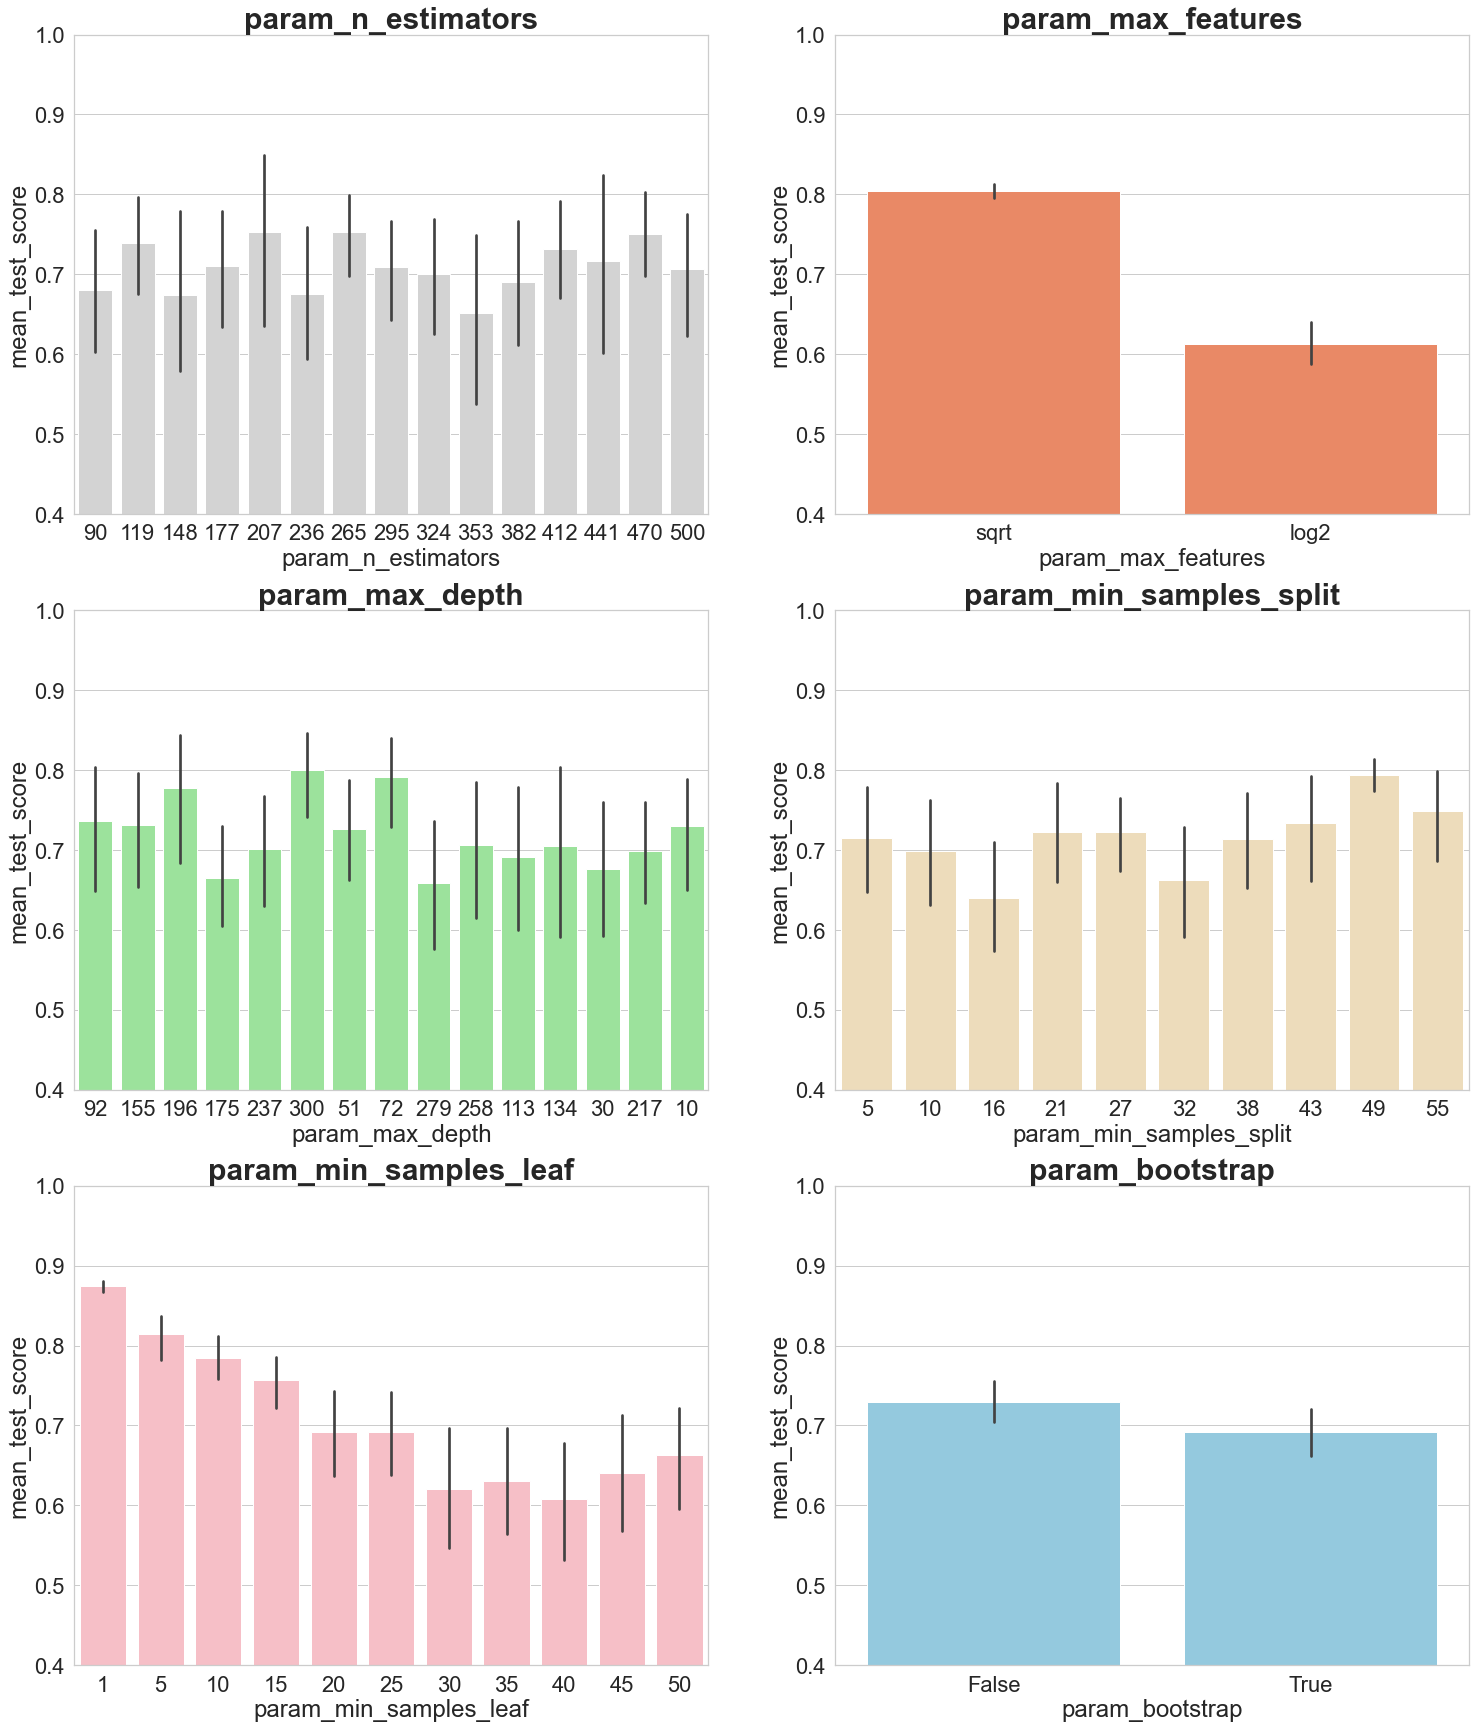

In [148]:
def ShowGraphics(param_dist, rs_df, min_scoring=0.4):
    colors = ['lightgrey', 'coral', 'lightgreen', 'wheat', 'lightpink', 
                'skyblue', 'forestgreen', 'maroon', 'olivedrab']
    params = ['param_' + x for x in list(param_dist.keys())]
    ncols, nrows = 2, len(params) // 2 + len(params) % 2
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows)
    sns.set(style="whitegrid", color_codes=True, font_scale=2)
    fig.set_size_inches(25, 30)

    for ind in range(len(params)):
        i = ind // ncols
        j = ind % ncols
        sns.barplot(x=params[ind], y='mean_test_score', data=rs_df, ax=axs[i, j], color=colors[ind])
        axs[i, j].set_ylim([min_scoring, 1])
        axs[i, j].set_title(label=params[ind], size=30, weight='bold')
    plt.show()


ShowGraphics(param_dist, rs_df)

Палочками на столбцах в графиках отображается погрешность. Из-за большого количества перебираемых параметров видим что погрешность достаточно большая у всех значений параметров min_samples_split, max_depth и n_estimators. 

Видим, что max_features = log2 в среднем дает результаты значительно хуже, чем max_features = sqrt, еще погрешность у этого значения параметра больше. Так же min_sample_leaf $\geq$ 15 дает плохие результаты и большую погрешность по сравнению со значениями min_sample_leaf $\leq$ 10.

Также посмотрим отчет о точности классификатора на данном этапе валидации, для того, чтобы в дальнейшем видеть улучшения.

In [115]:
def CalculateAccuracy(model, vectorizer, ds, confidence_level):
    ds['predict'] = model.predict(vectorizer.transform(ds['X']))
    ds['confidence'] = np.transpose(np.amax(model.predict_proba(vectorizer.transform(ds['X'])), axis=1))
    mean_confidence = np.mean(ds['confidence'])
    precision = round(100 * len(ds[(ds['confidence'] >= confidence_level) & (ds['target'] == ds['predict'])]) / len(ds), 2)
    to_validate = round(100 * len(ds[(ds['confidence'] < confidence_level)]) / len(ds), 2)
    return precision, to_validate, mean_confidence


def ShowStatistics(model_, vectorizer_, to_show_model=True):
    if to_show_model:
        print('model:', model_)
        print('vectorizer:', vectorizer_)
    precision, to_validate, mean_confidence = CalculateAccuracy(model_, vectorizer_, test.copy(), 0.8)
    prediction = model_.predict(vectorizer_.transform(test['X']))
    print('Rows in test set: {}'.format(len(test)))
    print('Statistics:')
    print('Precision = {}%; Ratio to validate = {}%; at confidence level = {}'.format(precision, to_validate, 0.8))
    print('Mean accuracy: {}%'.format(round(100 * accuracy_score(test['target'], prediction), 2)))
    print('Mean confidence: {}%'.format(round(100 * mean_confidence, 2)))
    print(classification_report(test['target'], prediction))

In [117]:
ShowStatistics(rs.best_estimator_, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_depth=92, max_features='sqrt',
                       min_samples_split=21, n_estimators=207)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 17041
Statistics:
Precision = 72.45%; Ratio to validate = 25.33%; at confidence level = 0.8
Mean accuracy: 89.26%
Mean confidence: 86.16%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.94      0.92      0.93      2931
                                            ad-invoice-multi       0.95      0.68      0.79       359
                                          ad-statement-first       0.97      1.00      0.98      3929
                                          ad-statement-multi       0.96      0.88      0.92       524
                                                ad-upd-first       0.89      0.95      0.92      2488
                  

## Второй раунд рандомизированной кросс валидации. 
Отсеим значения параметров, которые дают плохие результаты.

In [150]:
n_estimators = [int(x) for x in np.linspace(start=90, stop=500, num=15)]
max_depth = [int(x) for x in np.linspace(start=10, stop=300, num=15)] + [None]
min_samples_split = [int(x) for x in np.linspace(start=5, stop=55, num=10)]
min_samples_leaf = [int(x) for x in np.linspace(start=1, stop=10, num=5)]
bootstrap = [True, False]

param_dist = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf,
    'bootstrap' : bootstrap,
}
for key in param_dist.keys():
    print('{}: {}'.format(key, param_dist[key]))

n_estimators: [90, 119, 148, 177, 207, 236, 265, 295, 324, 353, 382, 412, 441, 470, 500]
max_depth: [10, 30, 51, 72, 92, 113, 134, 155, 175, 196, 217, 237, 258, 279, 300, None]
min_samples_split: [5, 10, 16, 21, 27, 32, 38, 43, 49, 55]
min_samples_leaf: [1, 3, 5, 7, 10]
bootstrap: [True, False]


In [120]:
rs2 = RunRandomizedCrossValidation(RandomForestClassifier(max_features='sqrt'), param_dist, 3, 170)

Fitting 3 folds for each of 170 candidates, totalling 510 fits


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


[CV 1/3] END bootstrap=True, max_depth=72, min_samples_leaf=7, min_samples_split=16, n_estimators=148;, score=0.852 total time=   4.8s
[CV 2/3] END bootstrap=True, max_depth=72, min_samples_leaf=7, min_samples_split=16, n_estimators=148;, score=0.845 total time=   4.7s
[CV 3/3] END bootstrap=True, max_depth=72, min_samples_leaf=7, min_samples_split=16, n_estimators=148;, score=0.849 total time=   5.1s
[CV 1/3] END bootstrap=True, max_depth=300, min_samples_leaf=3, min_samples_split=55, n_estimators=500;, score=0.872 total time=  16.1s
[CV 2/3] END bootstrap=True, max_depth=300, min_samples_leaf=3, min_samples_split=55, n_estimators=500;, score=0.860 total time=  16.4s
[CV 3/3] END bootstrap=True, max_depth=300, min_samples_leaf=3, min_samples_split=55, n_estimators=500;, score=0.863 total time=  16.7s
[CV 1/3] END bootstrap=True, max_depth=279, min_samples_leaf=1, min_samples_split=38, n_estimators=236;, score=0.882 total time=  10.2s
[CV 2/3] END bootstrap=True, max_depth=279, min_sam

[CV 2/3] END bootstrap=True, max_depth=72, min_samples_leaf=10, min_samples_split=21, n_estimators=148;, score=0.831 total time=   4.0s
[CV 3/3] END bootstrap=True, max_depth=72, min_samples_leaf=10, min_samples_split=21, n_estimators=148;, score=0.827 total time=   4.1s
[CV 1/3] END bootstrap=False, max_depth=134, min_samples_leaf=5, min_samples_split=49, n_estimators=119;, score=0.871 total time=   4.1s
[CV 2/3] END bootstrap=False, max_depth=134, min_samples_leaf=5, min_samples_split=49, n_estimators=119;, score=0.858 total time=   4.2s
[CV 3/3] END bootstrap=False, max_depth=134, min_samples_leaf=5, min_samples_split=49, n_estimators=119;, score=0.863 total time=   4.4s
[CV 1/3] END bootstrap=True, max_depth=175, min_samples_leaf=3, min_samples_split=27, n_estimators=265;, score=0.871 total time=   9.5s
[CV 2/3] END bootstrap=True, max_depth=175, min_samples_leaf=3, min_samples_split=27, n_estimators=265;, score=0.863 total time=   9.5s
[CV 3/3] END bootstrap=True, max_depth=175, m

[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=7, min_samples_split=55, n_estimators=236;, score=0.861 total time=   7.5s
[CV 1/3] END bootstrap=False, max_depth=113, min_samples_leaf=7, min_samples_split=49, n_estimators=119;, score=0.864 total time=   3.6s
[CV 2/3] END bootstrap=False, max_depth=113, min_samples_leaf=7, min_samples_split=49, n_estimators=119;, score=0.853 total time=   3.7s
[CV 3/3] END bootstrap=False, max_depth=113, min_samples_leaf=7, min_samples_split=49, n_estimators=119;, score=0.859 total time=   4.0s
[CV 1/3] END bootstrap=False, max_depth=217, min_samples_leaf=3, min_samples_split=27, n_estimators=412;, score=0.882 total time=  16.1s
[CV 2/3] END bootstrap=False, max_depth=217, min_samples_leaf=3, min_samples_split=27, n_estimators=412;, score=0.873 total time=  17.3s
[CV 3/3] END bootstrap=False, max_depth=217, min_samples_leaf=3, min_samples_split=27, n_estimators=412;, score=0.877 total time=  17.3s
[CV 1/3] END bootstrap=False, max_depth=

[CV 3/3] END bootstrap=False, max_depth=51, min_samples_leaf=3, min_samples_split=38, n_estimators=500;, score=0.872 total time=  20.9s
[CV 1/3] END bootstrap=False, max_depth=72, min_samples_leaf=10, min_samples_split=10, n_estimators=500;, score=0.855 total time=  16.5s
[CV 2/3] END bootstrap=False, max_depth=72, min_samples_leaf=10, min_samples_split=10, n_estimators=500;, score=0.847 total time=  16.1s
[CV 3/3] END bootstrap=False, max_depth=72, min_samples_leaf=10, min_samples_split=10, n_estimators=500;, score=0.851 total time=  16.8s
[CV 1/3] END bootstrap=False, max_depth=258, min_samples_leaf=5, min_samples_split=27, n_estimators=324;, score=0.871 total time=  11.5s
[CV 2/3] END bootstrap=False, max_depth=258, min_samples_leaf=5, min_samples_split=27, n_estimators=324;, score=0.864 total time=  12.4s
[CV 3/3] END bootstrap=False, max_depth=258, min_samples_leaf=5, min_samples_split=27, n_estimators=324;, score=0.864 total time=  13.2s
[CV 1/3] END bootstrap=False, max_depth=23

[CV 3/3] END bootstrap=False, max_depth=72, min_samples_leaf=1, min_samples_split=27, n_estimators=500;, score=0.886 total time=  26.8s
[CV 1/3] END bootstrap=True, max_depth=155, min_samples_leaf=1, min_samples_split=5, n_estimators=119;, score=0.891 total time=  12.6s
[CV 2/3] END bootstrap=True, max_depth=155, min_samples_leaf=1, min_samples_split=5, n_estimators=119;, score=0.880 total time=  11.6s
[CV 3/3] END bootstrap=True, max_depth=155, min_samples_leaf=1, min_samples_split=5, n_estimators=119;, score=0.891 total time=  12.5s
[CV 1/3] END bootstrap=True, max_depth=196, min_samples_leaf=3, min_samples_split=43, n_estimators=295;, score=0.873 total time=   9.1s
[CV 2/3] END bootstrap=True, max_depth=196, min_samples_leaf=3, min_samples_split=43, n_estimators=295;, score=0.861 total time=   9.6s
[CV 3/3] END bootstrap=True, max_depth=196, min_samples_leaf=3, min_samples_split=43, n_estimators=295;, score=0.863 total time=   9.7s
[CV 1/3] END bootstrap=True, max_depth=258, min_sam

[CV 1/3] END bootstrap=True, max_depth=196, min_samples_leaf=10, min_samples_split=10, n_estimators=90;, score=0.829 total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=196, min_samples_leaf=10, min_samples_split=10, n_estimators=90;, score=0.827 total time=   2.5s
[CV 3/3] END bootstrap=True, max_depth=196, min_samples_leaf=10, min_samples_split=10, n_estimators=90;, score=0.828 total time=   2.4s
[CV 1/3] END bootstrap=True, max_depth=237, min_samples_leaf=3, min_samples_split=21, n_estimators=177;, score=0.873 total time=   6.2s
[CV 2/3] END bootstrap=True, max_depth=237, min_samples_leaf=3, min_samples_split=21, n_estimators=177;, score=0.865 total time=   6.3s
[CV 3/3] END bootstrap=True, max_depth=237, min_samples_leaf=3, min_samples_split=21, n_estimators=177;, score=0.868 total time=   6.5s
[CV 1/3] END bootstrap=False, max_depth=279, min_samples_leaf=10, min_samples_split=16, n_estimators=236;, score=0.856 total time=   7.4s
[CV 2/3] END bootstrap=False, max_depth=279, m

[CV 2/3] END bootstrap=False, max_depth=300, min_samples_leaf=1, min_samples_split=49, n_estimators=265;, score=0.880 total time=  13.6s
[CV 3/3] END bootstrap=False, max_depth=300, min_samples_leaf=1, min_samples_split=49, n_estimators=265;, score=0.880 total time=  14.0s
[CV 1/3] END bootstrap=True, max_depth=258, min_samples_leaf=1, min_samples_split=49, n_estimators=177;, score=0.879 total time=   7.1s
[CV 2/3] END bootstrap=True, max_depth=258, min_samples_leaf=1, min_samples_split=49, n_estimators=177;, score=0.872 total time=   7.6s
[CV 3/3] END bootstrap=True, max_depth=258, min_samples_leaf=1, min_samples_split=49, n_estimators=177;, score=0.877 total time=   7.5s
[CV 1/3] END bootstrap=True, max_depth=279, min_samples_leaf=5, min_samples_split=49, n_estimators=353;, score=0.857 total time=   9.5s
[CV 2/3] END bootstrap=True, max_depth=279, min_samples_leaf=5, min_samples_split=49, n_estimators=353;, score=0.851 total time=  10.3s
[CV 3/3] END bootstrap=True, max_depth=279, mi

[CV 3/3] END bootstrap=False, max_depth=72, min_samples_leaf=1, min_samples_split=43, n_estimators=470;, score=0.885 total time=  23.5s
[CV 1/3] END bootstrap=True, max_depth=155, min_samples_leaf=1, min_samples_split=21, n_estimators=295;, score=0.883 total time=  14.3s
[CV 2/3] END bootstrap=True, max_depth=155, min_samples_leaf=1, min_samples_split=21, n_estimators=295;, score=0.879 total time=  14.2s
[CV 3/3] END bootstrap=True, max_depth=155, min_samples_leaf=1, min_samples_split=21, n_estimators=295;, score=0.882 total time=  15.1s
[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=5, min_samples_split=38, n_estimators=441;, score=0.852 total time=  12.9s
[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=5, min_samples_split=38, n_estimators=441;, score=0.845 total time=  12.7s
[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=5, min_samples_split=38, n_estimators=441;, score=0.850 total time=  12.4s
[CV 1/3] END bootstrap=False, max_depth=None, min_s

[CV 1/3] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=55, n_estimators=382;, score=0.868 total time=  14.0s
[CV 2/3] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=55, n_estimators=382;, score=0.860 total time=  15.0s
[CV 3/3] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=55, n_estimators=382;, score=0.865 total time=  15.0s
[CV 1/3] END bootstrap=True, max_depth=113, min_samples_leaf=3, min_samples_split=5, n_estimators=441;, score=0.876 total time=  19.5s
[CV 2/3] END bootstrap=True, max_depth=113, min_samples_leaf=3, min_samples_split=5, n_estimators=441;, score=0.868 total time=  19.7s
[CV 3/3] END bootstrap=True, max_depth=113, min_samples_leaf=3, min_samples_split=5, n_estimators=441;, score=0.870 total time=  19.4s
[CV 1/3] END bootstrap=False, max_depth=155, min_samples_leaf=7, min_samples_split=43, n_estimators=470;, score=0.865 total time=  14.5s
[CV 2/3] END bootstrap=False, max_depth=155, min_s

In [121]:
rs2_df = GetResultsDataFrame(rs2)
rs2_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,148,5,1,279,False,0.892301,1
1,382,10,1,175,False,0.891073,2
2,412,21,1,None,False,0.890800,3
3,207,5,1,72,False,0.890663,4
4,412,16,1,92,False,0.890254,5
5,412,21,1,300,False,0.889571,6
6,265,21,1,300,False,0.889298,7
7,324,27,1,175,False,0.889298,7
8,353,27,1,196,False,0.888889,9
9,441,5,1,113,True,0.887933,10


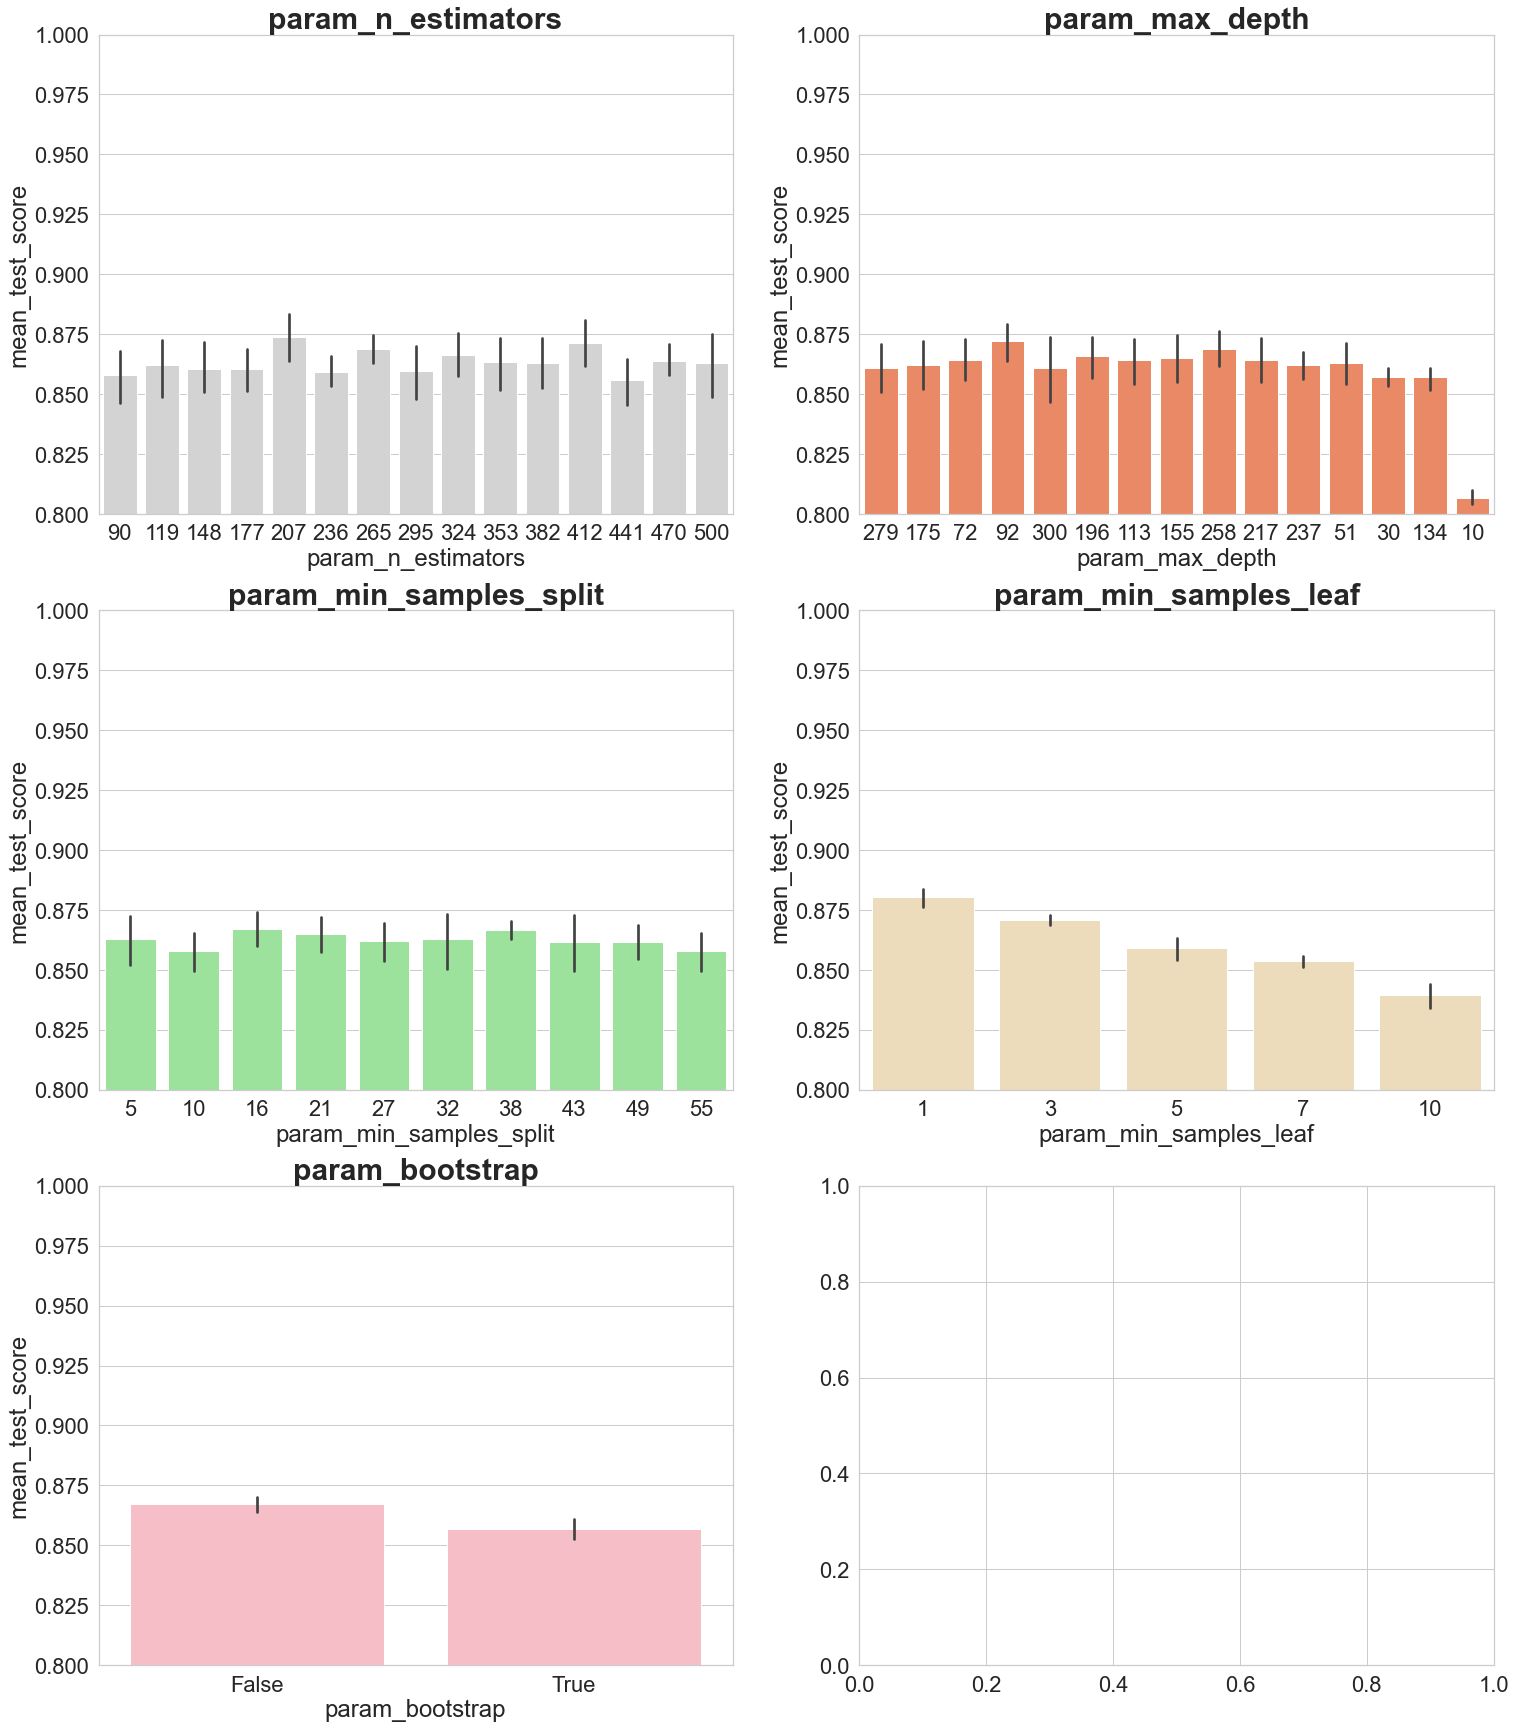

In [151]:
ShowGraphics(param_dist, rs2_df, 0.8)

Видим, что точность классификатора уменьшается с увеличением параметра min_samples_leaf, так же отметим, что bootstrap = True дает чуть хуже результаты, чем bootstrap = False. Также видим, что max_depth = 10 показывает плохой результат по сравнению с другими значениями. Насчет остальных параметров: в целом они дают приблизительно одинаковые значения точности.

Отсеим bootstrap = True, min_samples_leaf > 1 и max_depth < 30.

Также для полноты картины посмотрим отчет о точности классификатора на данном этапе валидации.

In [124]:
ShowStatistics(rs.best_estimator_, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_depth=92, max_features='sqrt',
                       min_samples_split=21, n_estimators=207)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 17041
Statistics:
Precision = 72.45%; Ratio to validate = 25.33%; at confidence level = 0.8
Mean accuracy: 89.26%
Mean confidence: 86.16%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.94      0.92      0.93      2931
                                            ad-invoice-multi       0.95      0.68      0.79       359
                                          ad-statement-first       0.97      1.00      0.98      3929
                                          ad-statement-multi       0.96      0.88      0.92       524
                                                ad-upd-first       0.89      0.95      0.92      2488
                  

# Третий раунд кросс валидации
На этом этапе детальнее изучим диапазоны параметров, которые показали наиболее хорошие показатели

In [156]:
n_estimators = [int(x) for x in np.linspace(start=90, stop=510, num=14)]
max_depth = [int(x) for x in np.linspace(start=30, stop=300, num=10)] + [None]
min_samples_split = [int(x) for x in np.linspace(start=5, stop=55, num=11)]

param_dist = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'min_samples_split' : min_samples_split,
}
for key in param_dist.keys():
    print('{}: {}'.format(key, param_dist[key]))

n_estimators: [90, 122, 154, 186, 219, 251, 283, 316, 348, 380, 413, 445, 477, 510]
max_depth: [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, None]
min_samples_split: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]


In [157]:
rs3 = RunRandomizedCrossValidation(RandomForestClassifier(max_features='sqrt', bootstrap=False, min_samples_leaf=1), param_dist, 3, 100)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


[CV 1/3] END max_depth=60, min_samples_split=35, n_estimators=445;, score=0.887 total time=  21.1s
[CV 2/3] END max_depth=60, min_samples_split=35, n_estimators=445;, score=0.880 total time=  24.3s
[CV 3/3] END max_depth=60, min_samples_split=35, n_estimators=445;, score=0.883 total time=  23.5s
[CV 1/3] END max_depth=30, min_samples_split=5, n_estimators=283;, score=0.876 total time=  17.9s
[CV 2/3] END max_depth=30, min_samples_split=5, n_estimators=283;, score=0.869 total time=  17.3s
[CV 3/3] END max_depth=30, min_samples_split=5, n_estimators=283;, score=0.873 total time=  21.9s
[CV 1/3] END max_depth=30, min_samples_split=45, n_estimators=477;, score=0.869 total time=  18.2s
[CV 2/3] END max_depth=30, min_samples_split=45, n_estimators=477;, score=0.861 total time=  18.3s
[CV 3/3] END max_depth=30, min_samples_split=45, n_estimators=477;, score=0.864 total time=  18.8s
[CV 1/3] END max_depth=30, min_samples_split=15, n_estimators=283;, score=0.871 total time=  12.0s
[CV 2/3] END 

[CV 3/3] END max_depth=270, min_samples_split=5, n_estimators=413;, score=0.895 total time= 1.2min
[CV 1/3] END max_depth=270, min_samples_split=15, n_estimators=316;, score=0.893 total time=  19.3s
[CV 2/3] END max_depth=270, min_samples_split=15, n_estimators=316;, score=0.887 total time=  19.9s
[CV 3/3] END max_depth=270, min_samples_split=15, n_estimators=316;, score=0.892 total time=  20.6s
[CV 1/3] END max_depth=210, min_samples_split=35, n_estimators=283;, score=0.889 total time=  14.2s
[CV 2/3] END max_depth=210, min_samples_split=35, n_estimators=283;, score=0.882 total time=  14.3s
[CV 3/3] END max_depth=210, min_samples_split=35, n_estimators=283;, score=0.887 total time=  15.0s
[CV 1/3] END max_depth=120, min_samples_split=35, n_estimators=90;, score=0.889 total time=   4.5s
[CV 2/3] END max_depth=120, min_samples_split=35, n_estimators=90;, score=0.882 total time=   4.7s
[CV 3/3] END max_depth=120, min_samples_split=35, n_estimators=90;, score=0.885 total time=   4.8s
[CV 

[CV 2/3] END max_depth=90, min_samples_split=50, n_estimators=380;, score=0.881 total time=  18.5s
[CV 3/3] END max_depth=90, min_samples_split=50, n_estimators=380;, score=0.880 total time=  19.7s
[CV 1/3] END max_depth=None, min_samples_split=5, n_estimators=413;, score=0.898 total time=  55.6s
[CV 2/3] END max_depth=None, min_samples_split=5, n_estimators=413;, score=0.885 total time=  55.3s
[CV 3/3] END max_depth=None, min_samples_split=5, n_estimators=413;, score=0.896 total time= 1.2min
[CV 1/3] END max_depth=300, min_samples_split=45, n_estimators=316;, score=0.888 total time=  14.8s
[CV 2/3] END max_depth=300, min_samples_split=45, n_estimators=316;, score=0.881 total time=  15.4s
[CV 3/3] END max_depth=300, min_samples_split=45, n_estimators=316;, score=0.885 total time=  16.0s
[CV 1/3] END max_depth=300, min_samples_split=45, n_estimators=380;, score=0.890 total time=  17.8s
[CV 2/3] END max_depth=300, min_samples_split=45, n_estimators=380;, score=0.878 total time=  18.7s
[C

[CV 1/3] END max_depth=180, min_samples_split=50, n_estimators=445;, score=0.894 total time=  20.7s
[CV 2/3] END max_depth=180, min_samples_split=50, n_estimators=445;, score=0.880 total time=  21.3s
[CV 3/3] END max_depth=180, min_samples_split=50, n_estimators=445;, score=0.887 total time=  22.4s
[CV 1/3] END max_depth=300, min_samples_split=45, n_estimators=413;, score=0.890 total time=  19.9s
[CV 2/3] END max_depth=300, min_samples_split=45, n_estimators=413;, score=0.878 total time=  20.7s
[CV 3/3] END max_depth=300, min_samples_split=45, n_estimators=413;, score=0.885 total time=  21.4s
[CV 1/3] END max_depth=210, min_samples_split=30, n_estimators=445;, score=0.892 total time=  22.9s
[CV 2/3] END max_depth=210, min_samples_split=30, n_estimators=445;, score=0.882 total time=  24.3s
[CV 3/3] END max_depth=210, min_samples_split=30, n_estimators=445;, score=0.887 total time=  26.6s
[CV 1/3] END max_depth=None, min_samples_split=40, n_estimators=445;, score=0.893 total time=  22.3s

In [158]:
rs3_df = GetResultsDataFrame(rs3)
rs3_df.head(10)

,param_n_estimators,param_min_samples_split,param_max_depth,mean_test_score,rank_test_score
0,445,10,270,0.892711,1
1,413,5,None,0.892711,1
2,413,10,300,0.892165,3
3,445,10,240,0.892028,4
4,413,5,270,0.891892,5
5,122,20,180,0.891892,6
6,477,5,210,0.891892,6
7,122,10,None,0.891755,8
8,316,10,120,0.891482,9
9,154,10,150,0.891346,10


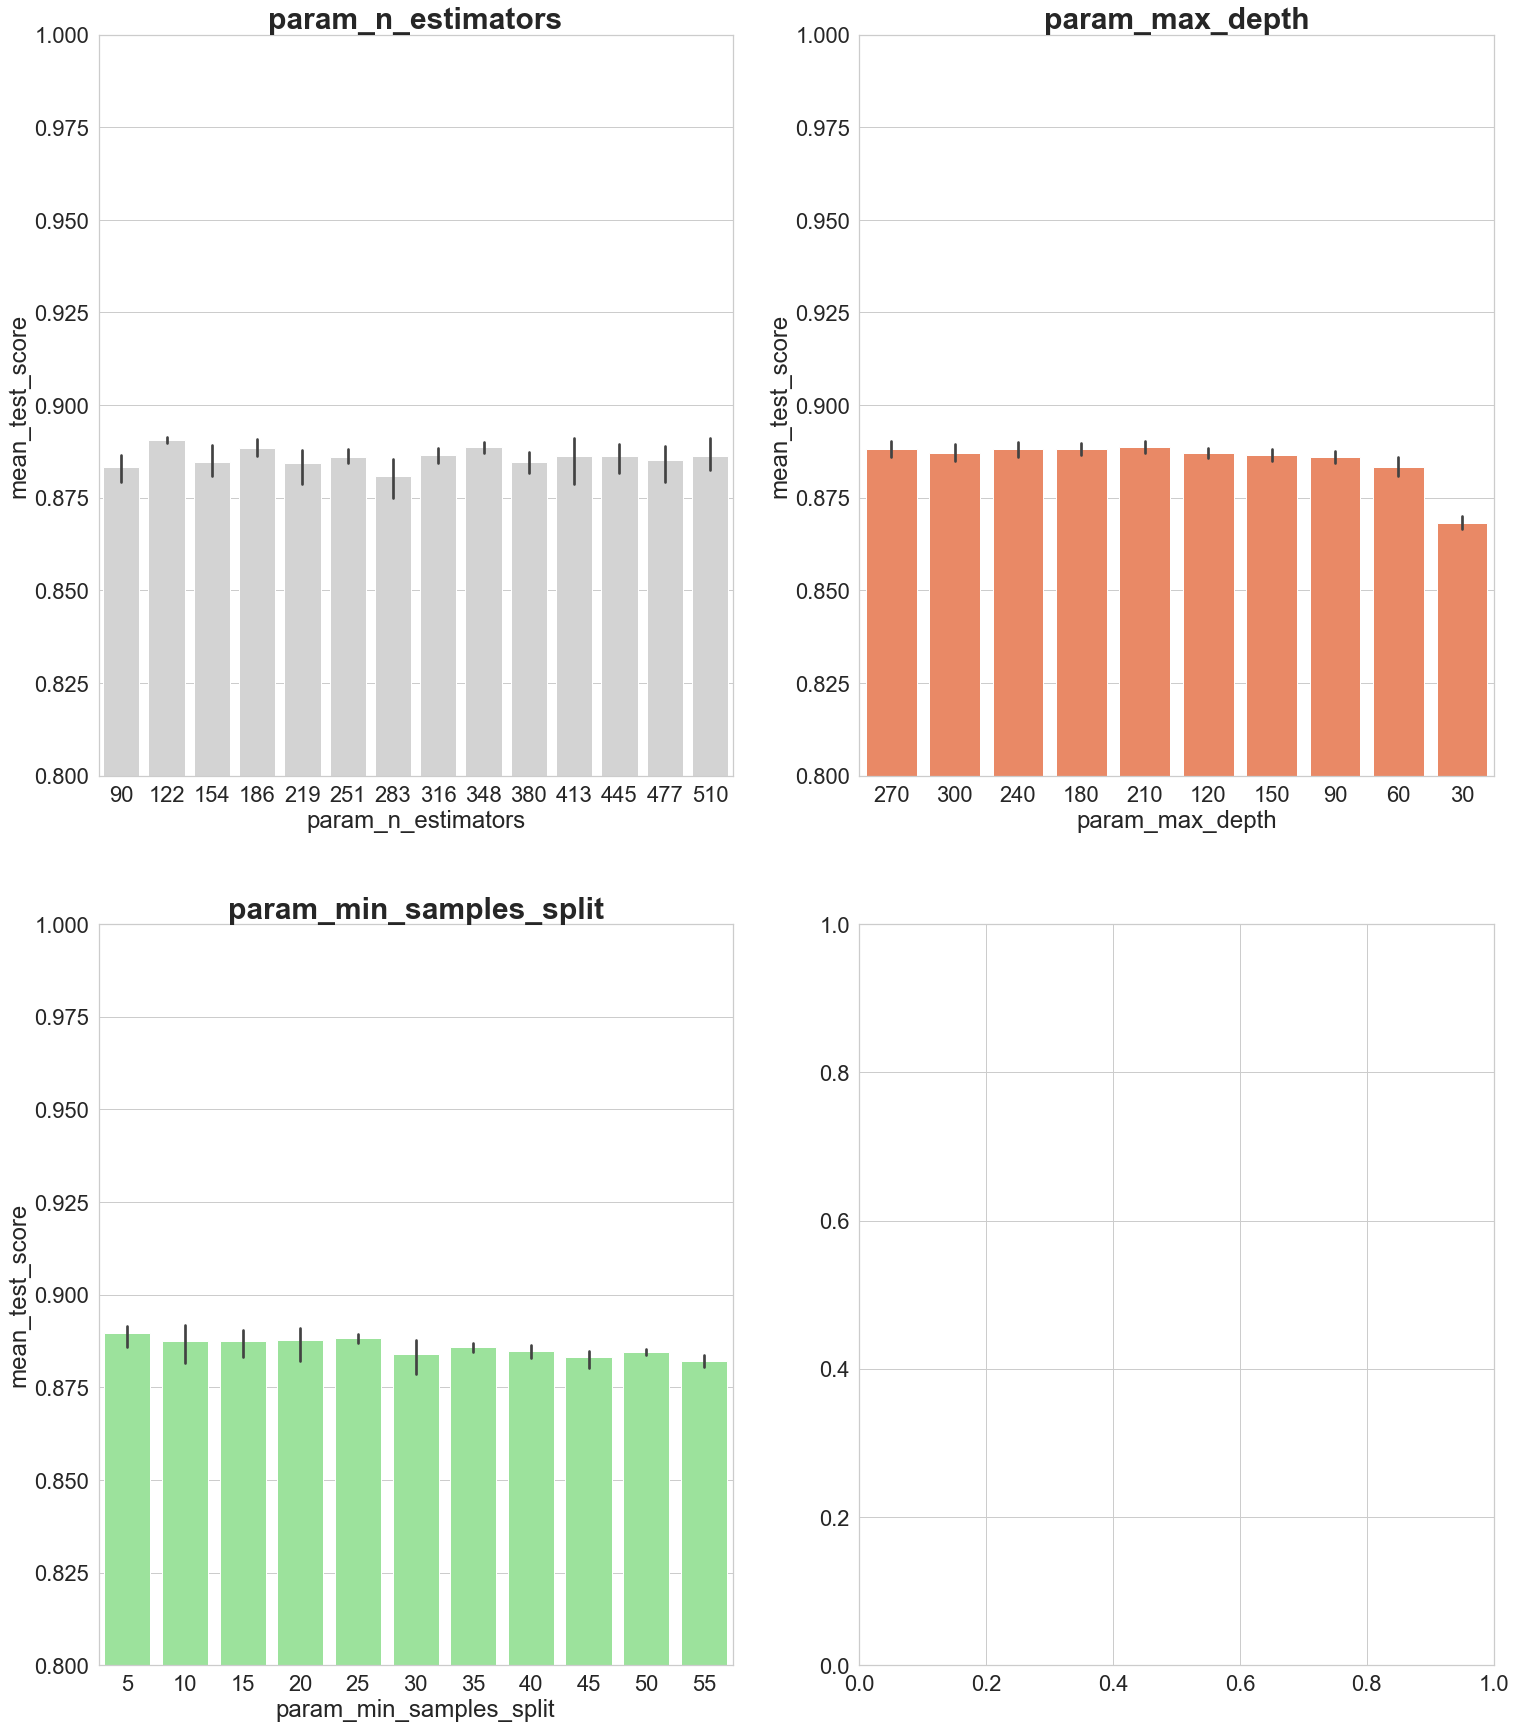

In [159]:
ShowGraphics(param_dist, rs3_df, 0.8)

# Финальный раунд кросс валидации
На этом этапе отберем несколько параметров, которые на предыдущих этапах дали наилучшие значения точности, и переберем все комбинации этих параметров

In [160]:
def GetBestArgs(rs_df, param):
    a = rs_df.groupby(param).mean_test_score.mean().to_dict()
    srtd = [(a[key], key) for key in a.keys()]
    srtd.sort(key=lambda x: -x[0])
    srtd = [x[1] for x in srtd]
    return srtd

In [162]:
best_n_estimators = GetBestArgs(rs_df, 'param_n_estimators')[:6]
best_max_depth = [None] + GetBestArgs(rs_df, 'param_max_depth')[:4]
best_min_samples_split = GetBestArgs(rs_df, 'param_min_samples_split')[:4]

param_dist = {
    'n_estimators' : best_n_estimators,
    'max_depth' : best_max_depth,
    'min_samples_split' : best_min_samples_split,
}
for key in param_dist.keys():
    print('{}: {}'.format(key, param_dist[key]))

n_estimators: [207, 265, 470, 119, 412, 441]
max_depth: [None, 300, 72, 196, 92]
min_samples_split: [49, 55, 43, 27]


In [164]:
rf = RandomForestClassifier(bootstrap=False, max_features='sqrt', min_samples_leaf=1)
gs = GridSearchCV(rf, param_dist, cv=3, verbose=3, n_jobs=1)
gs.fit(X_train, Y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


[CV 1/3] END max_depth=None, min_samples_split=49, n_estimators=207;, score=0.887 total time=  10.4s
[CV 2/3] END max_depth=None, min_samples_split=49, n_estimators=207;, score=0.880 total time=  10.3s
[CV 3/3] END max_depth=None, min_samples_split=49, n_estimators=207;, score=0.887 total time=  11.0s
[CV 1/3] END max_depth=None, min_samples_split=49, n_estimators=265;, score=0.887 total time=  12.8s
[CV 2/3] END max_depth=None, min_samples_split=49, n_estimators=265;, score=0.881 total time=  13.3s
[CV 3/3] END max_depth=None, min_samples_split=49, n_estimators=265;, score=0.884 total time=  13.6s
[CV 1/3] END max_depth=None, min_samples_split=49, n_estimators=470;, score=0.890 total time=  22.3s
[CV 2/3] END max_depth=None, min_samples_split=49, n_estimators=470;, score=0.879 total time=  23.8s
[CV 3/3] END max_depth=None, min_samples_split=49, n_estimators=470;, score=0.883 total time=  24.6s
[CV 1/3] END max_depth=None, min_samples_split=49, n_estimators=119;, score=0.889 total tim

[CV 2/3] END max_depth=300, min_samples_split=49, n_estimators=119;, score=0.876 total time=   5.9s
[CV 3/3] END max_depth=300, min_samples_split=49, n_estimators=119;, score=0.884 total time=   6.3s
[CV 1/3] END max_depth=300, min_samples_split=49, n_estimators=412;, score=0.892 total time=  19.9s
[CV 2/3] END max_depth=300, min_samples_split=49, n_estimators=412;, score=0.878 total time=  20.6s
[CV 3/3] END max_depth=300, min_samples_split=49, n_estimators=412;, score=0.885 total time=  23.7s
[CV 1/3] END max_depth=300, min_samples_split=49, n_estimators=441;, score=0.891 total time=  22.0s
[CV 2/3] END max_depth=300, min_samples_split=49, n_estimators=441;, score=0.878 total time=  22.3s
[CV 3/3] END max_depth=300, min_samples_split=49, n_estimators=441;, score=0.885 total time=  23.4s
[CV 1/3] END max_depth=300, min_samples_split=55, n_estimators=207;, score=0.891 total time=  10.0s
[CV 2/3] END max_depth=300, min_samples_split=55, n_estimators=207;, score=0.878 total time=  10.2s


[CV 1/3] END max_depth=72, min_samples_split=55, n_estimators=265;, score=0.888 total time=  12.2s
[CV 2/3] END max_depth=72, min_samples_split=55, n_estimators=265;, score=0.878 total time=  12.5s
[CV 3/3] END max_depth=72, min_samples_split=55, n_estimators=265;, score=0.881 total time=  13.0s
[CV 1/3] END max_depth=72, min_samples_split=55, n_estimators=470;, score=0.886 total time=  21.3s
[CV 2/3] END max_depth=72, min_samples_split=55, n_estimators=470;, score=0.876 total time=  22.1s
[CV 3/3] END max_depth=72, min_samples_split=55, n_estimators=470;, score=0.882 total time=  22.6s
[CV 1/3] END max_depth=72, min_samples_split=55, n_estimators=119;, score=0.886 total time=   5.3s
[CV 2/3] END max_depth=72, min_samples_split=55, n_estimators=119;, score=0.877 total time=   5.5s
[CV 3/3] END max_depth=72, min_samples_split=55, n_estimators=119;, score=0.882 total time=   5.8s
[CV 1/3] END max_depth=72, min_samples_split=55, n_estimators=412;, score=0.885 total time=  18.6s
[CV 2/3] E

[CV 3/3] END max_depth=196, min_samples_split=55, n_estimators=412;, score=0.883 total time=  20.6s
[CV 1/3] END max_depth=196, min_samples_split=55, n_estimators=441;, score=0.889 total time=  20.8s
[CV 2/3] END max_depth=196, min_samples_split=55, n_estimators=441;, score=0.880 total time=  21.2s
[CV 3/3] END max_depth=196, min_samples_split=55, n_estimators=441;, score=0.885 total time=  22.8s
[CV 1/3] END max_depth=196, min_samples_split=43, n_estimators=207;, score=0.892 total time=  10.6s
[CV 2/3] END max_depth=196, min_samples_split=43, n_estimators=207;, score=0.878 total time=  10.9s
[CV 3/3] END max_depth=196, min_samples_split=43, n_estimators=207;, score=0.884 total time=  11.3s
[CV 1/3] END max_depth=196, min_samples_split=43, n_estimators=265;, score=0.892 total time=  12.9s
[CV 2/3] END max_depth=196, min_samples_split=43, n_estimators=265;, score=0.882 total time=  13.4s
[CV 3/3] END max_depth=196, min_samples_split=43, n_estimators=265;, score=0.885 total time=  13.9s


[CV 2/3] END max_depth=92, min_samples_split=43, n_estimators=470;, score=0.880 total time=  23.1s
[CV 3/3] END max_depth=92, min_samples_split=43, n_estimators=470;, score=0.886 total time=  24.0s
[CV 1/3] END max_depth=92, min_samples_split=43, n_estimators=119;, score=0.888 total time=   5.8s
[CV 2/3] END max_depth=92, min_samples_split=43, n_estimators=119;, score=0.876 total time=   5.8s
[CV 3/3] END max_depth=92, min_samples_split=43, n_estimators=119;, score=0.882 total time=   6.1s
[CV 1/3] END max_depth=92, min_samples_split=43, n_estimators=412;, score=0.890 total time=  19.2s
[CV 2/3] END max_depth=92, min_samples_split=43, n_estimators=412;, score=0.880 total time=  20.0s
[CV 3/3] END max_depth=92, min_samples_split=43, n_estimators=412;, score=0.884 total time=  21.1s
[CV 1/3] END max_depth=92, min_samples_split=43, n_estimators=441;, score=0.887 total time=  20.5s
[CV 2/3] END max_depth=92, min_samples_split=43, n_estimators=441;, score=0.879 total time=  21.6s
[CV 3/3] E

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              max_features='sqrt'),
             n_jobs=1,
             param_grid={'max_depth': [None, 300, 72, 196, 92],
                         'min_samples_split': [49, 55, 43, 27],
                         'n_estimators': [207, 265, 470, 119, 412, 441]},
             verbose=3)

In [167]:
gs_df = GetResultsDataFrame(gs)
gs_df.head(10)

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,rank_test_score
0,196,27,441,0.889844,1
1,196,27,470,0.889844,2
2,300,27,470,0.889435,3
3,196,27,119,0.889162,4
4,None,27,441,0.889162,5
5,None,27,265,0.889025,6
6,None,27,412,0.889025,6
7,None,27,119,0.888752,8
8,300,27,441,0.888616,9
9,None,27,470,0.888479,10


In [166]:
ShowStatistics(gs.best_estimator_, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_depth=196, max_features='sqrt',
                       min_samples_split=27, n_estimators=441)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 17041
Statistics:
Precision = 72.13%; Ratio to validate = 25.63%; at confidence level = 0.8
Mean accuracy: 89.27%
Mean confidence: 85.82%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.94      0.92      0.93      2931
                                            ad-invoice-multi       0.95      0.69      0.80       359
                                          ad-statement-first       0.97      0.99      0.98      3929
                                          ad-statement-multi       0.96      0.88      0.92       524
                                                ad-upd-first       0.89      0.96      0.92      2488
                 

In [174]:
ShowStatistics(gs.best_estimator_, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_depth=160, max_features='sqrt',
                       min_samples_split=10, n_estimators=200)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 17041
Statistics:
Precision = 74.72%; Ratio to validate = 22.61%; at confidence level = 0.8
Mean accuracy: 89.8%
Mean confidence: 87.37%


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.94      0.93      0.93      2931
                                            ad-invoice-multi       0.87      0.70      0.78       359
                                          ad-statement-first       0.97      0.99      0.98      3929
                                          ad-statement-multi       0.97      0.89      0.93       524
                                                ad-upd-first       0.89      0.96      0.92      2488
                                                ad-upd-multi       0.91      0.76      0.83       520
                                            ad-waybill-first       0.94      0.96      0.95       985
                                            ad-waybill-multi       1.00      0.65      0.79       139
                                                     rfq-AOG       0.84      0.61

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [158]:
# amount of zero-precision reduced
ShowStatistics(gs.best_estimator_, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_depth=170, max_features='sqrt',
                       min_samples_split=10, n_estimators=190)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 17041
Statistics:
Precision = 75.21%; Ratio to validate = 21.95%; at confidence level = 0.8
Mean accuracy: 89.34%
Mean confidence: 87.67%


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.92      0.93      0.92      2931
                                            ad-invoice-multi       0.93      0.72      0.81       359
                                          ad-statement-first       0.97      0.99      0.98      3929
                                          ad-statement-multi       0.98      0.87      0.92       524
                                                ad-upd-first       0.90      0.93      0.91      2488
                                                ad-upd-multi       0.88      0.81      0.85       520
                                            ad-waybill-first       0.95      0.95      0.95       985
                                            ad-waybill-multi       1.00      0.68      0.81       139
                                                     rfq-AOG       0.86      0.57

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [141]:
# good precision
ShowStatistics(gs.best_estimator_, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_depth=160, max_features='sqrt',
                       min_samples_split=10, n_estimators=200)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 4874
Statistics:
Precision = 77.84%; Ratio to validate = 19.86%; at confidence level = 0.8
Mean accuracy: 90.83%
Mean confidence: 89.16%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.95      0.94      0.94       864
                                            ad-invoice-multi       0.94      0.73      0.83       116
                                          ad-statement-first       0.98      0.99      0.99      1135
                                          ad-statement-multi       0.97      0.91      0.94       149
                                                ad-upd-first       0.92      0.96      0.94       689
                  

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
# good macro avg
ShowStatistics(gs.best_estimator_, vectorizer)

model: RandomForestClassifier(max_depth=130, min_samples_split=10, n_estimators=120)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 4874
Statistics:
Precision = 75.48%; Ratio to validate = 22.38%; at confidence level = 0.8
Mean accuracy: 89.95%
Mean confidence: 87.63%


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.94      0.93      0.94       828
                                            ad-invoice-multi       0.98      0.67      0.79       127
                                          ad-statement-first       0.98      0.99      0.99      1148
                                          ad-statement-multi       0.98      0.92      0.95       160
                                                ad-upd-first       0.90      0.95      0.92       714
                                                ad-upd-multi       0.85      0.83      0.84       149
                                            ad-waybill-first       0.94      0.97      0.95       293
                                            ad-waybill-multi       0.96      0.68      0.79        34
                                                     rfq-AOG       0.82      0.57

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
# write model to file
if 'models' not in os.listdir():
    os.mkdir('models')
with open('./models/doc_classifyer-model', 'wb') as f:
    pickle.dump(model, f)
with open('./models/doc_classifyer-vectorizer', 'wb') as f:
    pickle.dump(vectorizer, f)

In [100]:
# read model from file
with open('./models/doc_classifyer-model', 'rb') as f:
    model = pickle.load(f)
with open('./models/doc_classifyer-vectorizer', 'rb') as f:
    vectorizer = pickle.load(f)

In [101]:
ShowStatistics(model, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=20, n_estimators=127)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 4874
Statistics:
Precision = 67.42%; Ratio to validate = 32.11%; at confidence level = 0.8
Mean accuracy: 91.49%
Mean confidence: 84.14%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.97      0.94      0.96       828
                                            ad-invoice-multi       0.97      0.72      0.82       127
                                          ad-statement-first       0.99      1.00      0.99      1148
                                          ad-statement-multi       0.99      0.96      0.97       160
                                                ad-upd-first       0.91      0.99      0.95       714
                                 

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
ShowStatistics(model, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=20, n_estimators=127)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 4874
Statistics:
Precision = 67.77%; Ratio to validate = 31.64%; at confidence level = 0.8
Mean accuracy: 92.53%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.98      0.94      0.96       812
                                            ad-invoice-multi       0.94      0.80      0.86        99
                                          ad-statement-first       0.99      1.00      0.99      1157
                                          ad-statement-multi       0.99      0.95      0.97       164
                                                ad-upd-first       0.92      0.99      0.95       719
                                                ad-upd-mu

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
ShowStatistics(model, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=20, n_estimators=127)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 4874
Statistics:
Precision = 68.86%; Ratio to validate = 30.84%; at confidence level = 0.8
Mean accuracy: 91.61%
                                                           precision    recall  f1-score   support

                                         ad-invoice-first       0.98      0.93      0.96       831
                                         ad-invoice-multi       0.96      0.77      0.85        94
                                       ad-statement-first       0.99      1.00      0.99      1154
                                       ad-statement-multi       0.98      0.93      0.96       132
                                             ad-upd-first       0.89      0.99      0.94       712
                                             ad-upd-multi       0.96      0

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
